# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process

In [1]:
!pip install einops dm-haiku optax
!pip install dm-tree graphviz imageio[ffmpeg]

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os

colab = False

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

2022-12-01 11:09:53.048123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 11:09:53.536672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-12-01 11:09:53.536925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-12-01 11:09:53.536954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [3]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

In [4]:
train_new_model = True

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/"
  dataset_path = "/home/varun/tensorflow_datasets/"
else:
  data_paths = F"/content/gdrive/MyDrive/EMNIST/data/"
  model_paths = F"/content/gdrive/MyDrive/EMNIST/model/"
  gifs_dir = F"/content/gdrive/MyDrive/EMNIST/gifs/"
  dataset_path = F"/content/gdrive/MyDrive/EMNIST/dataset/"

In [5]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.05)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [7]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)

# how to add noise to the data
# @jax.jit
def get_noisy(batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    key = jax.random.PRNGKey(42)
    # need to generate new keys everytime
    noise_at_t = jax.random.normal(key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7faa680ff310>],
 [<matplotlib.lines.Line2D at 0x7faa6810c430>])

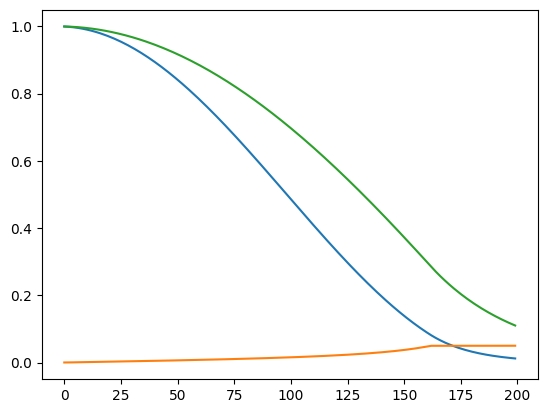

In [8]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_))

In [9]:
EMNIST_MEAN = (0.13066373765468597)
EMNIST_STD = (0.30810782313346863)

# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.sum(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  # cache the dataset to memory and repeat it indefinitely, epochs have reshuffled ordered data since *reshuffle_each_iteration* defaults to TRUE
  ds = tfds.load('emnist', split=split, data_dir=dataset_path, as_supervised=True).cache().repeat()
  if is_training:
    # shuffle the batches to improve generalization of the trained network
    ds = ds.shuffle(400 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Recommended: this can be jit'd and it should result in faster training time 
@jax.jit
def compute_loss(params: hk.Params, batch: Batch, is_energy_method: bool=False) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, _, timestep, noise = batch
  pred_data = net.apply(params, x, timestep)
  
  def error_func():
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_ 

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  loss_value, grads = jax.value_and_grad(compute_loss)(params, batch, is_energy_method)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def normalize(images):
  # numpy array creation could be moved out of the method
  mean = np.asarray(EMNIST_MEAN)
  std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32) / 255.

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x -= mean  # operations uses numpy broadcasting to work correctly
  x /= std 

  return x

@jax.jit
def unnormalize(images):
  mean = np.asarray(EMNIST_MEAN)
  std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32)

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x *= std 
  x += mean  # operations uses numpy broadcasting to work correctly
  
  return x*255.
  

In [10]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
batch_size=256
train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [11]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(train)[0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(einops.repeat(normalize(image), 'h w c -> b h w c', b=timesteps//10), jnp.arange(1, timesteps, 10))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir+'diffusion.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

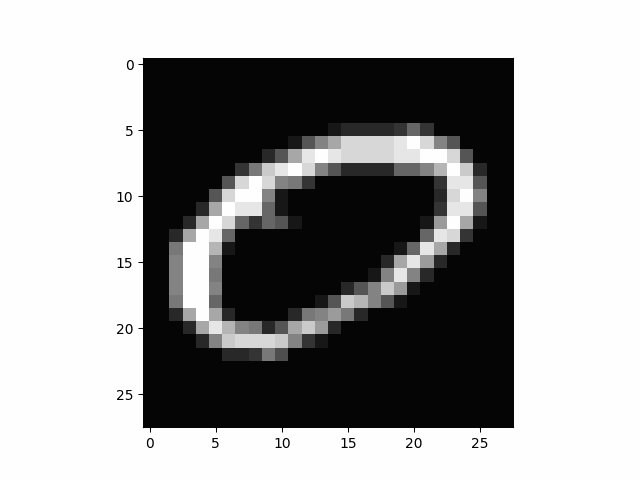

In [12]:
with open(gifs_dir + 'diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [13]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return jax.nn.selu(self.conv(x))
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return jax.nn.selu(self.conv(x))
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME')
    self.ln = hk.LayerNorm(axis=-1, param_axis=-1, create_scale=True, create_offset=True)
    self.seq = hk.Sequential([
      jax.nn.silu,
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      hk.LayerNorm(axis=-1, param_axis=-1, create_scale=True, create_offset=True),
      jax.nn.silu,
    ])
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      TimeEmbeddings(dims),
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timesteps=None):
    h = self.proj(x)
    h = self.ln(h)
    if timesteps is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timesteps)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.seq(h)
    return self.out_conv(x) + h

In [14]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=32, kernel_shape = (5,5), padding='SAME')
    self.block1 = Block(output_channels=32, kernel_size=3, padding=1)
    self.downsample1 = Downsample(64)
    self.block2 = Block(output_channels=64, kernel_size=3, padding=1)
    self.downsample2 = Downsample(128)
    self.middle_block = Block(output_channels=128, kernel_size=3, padding=1)
    self.upsample1 = Upsample(64)
    self.block3 = Block(output_channels=64, kernel_size=3, padding=1)
    self.upsample2 = Upsample(32)
    self.block4 = Block(output_channels=32, kernel_size=3, padding=1)
    self.seq = hk.Sequential([
        hk.Conv2D(output_channels=32, kernel_shape = (3,3), padding='SAME'),
        hk.LayerNorm(axis=-1, param_axis=-1, create_scale=True, create_offset=True),
        jax.nn.silu,
        hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME'),
    ])
      
  def __call__(self, x, timesteps):
    h = self.init_conv(x)
    b1 = self.block1(h, timesteps)
    h = self.downsample1(b1)
    b2 = self.block2(h, timesteps)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, timesteps))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), timesteps)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), timesteps)
    h = self.seq(h)
    return h

In [20]:
import graphviz

def f(x, timesteps):
  unet = UNet()
  return unet(x, timesteps)

f_t = hk.transform(f)

x = normalize(next(train)[0])[0] #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, 1)

rng = jax.random.PRNGKey(42)
params = f_t.init(rng, x, timesteps_)

# dot = hk.experimental.to_dot(f_t.apply)(params, None, x, timesteps)
# graphviz.Source(dot)

# print(hk.experimental.tabulate(f_t)(x, timesteps_))



---




### Training

In [21]:
# net_fn = UNet()
net = hk.without_apply_rng(f_t)

# Do not change learning rate
opt = optax.adam(1e-3)

# Recommended: param objects should be deepcopied, although in this case it doesn't cause issues
# we draw an input to get shapes.
# params = net.init(jax.random.PRNGKey(42), next(train), timesteps_)
avg_params = deepcopy(params)
opt_state = opt.init(params)

In [22]:
def save(ckpt_dir: str, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "wb") as f:
    for x in jax.tree_util.tree_leaves(state):
         np.save(f, x, allow_pickle=False)
    tree_struct = jax.tree_map(lambda t: 0, state)
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "wb") as f:
     pickle.dump(tree_struct, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "rb") as f:
    tree_struct = pickle.load(f)
 
  leaves, treedef = jax.tree_util.tree_flatten(tree_struct)
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "rb") as f:
    flat_state = [np.load(f) for _ in leaves]

  return jax.tree_util.tree_unflatten(treedef, flat_state)

def test_model_save():
  save('saved/saved_models/', avg_params, 'emnist_model')
  avg_params = restore('saved/saved_models/', 'emnist_model')

In [23]:
def show_predicted_image(noisy_image, params, timestep):
  print('time step for image', timestep)
  timestep = jnp.array([timestep])
  pred_noise = net.apply(params, noisy_image, timestep)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

time step for image 199


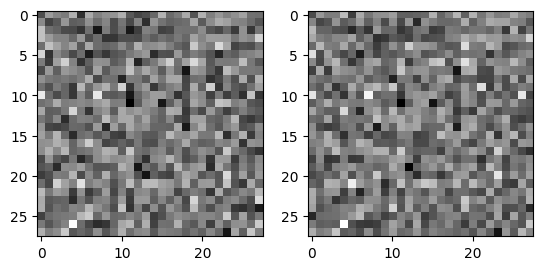

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

[4799.931]


In [24]:
def test_loss_fn():
  b, l = next(train)
  b = normalize(b)
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, [einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), jax.nn.one_hot(l, 63), tt, 
                                                          einops.rearrange(noise_temp[0], 'h w c -> 1 h w c')], False)))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp = net.apply(avg_params, einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), tt)
    model_huber_loss.append(huber_loss(einops.rearrange(pp[0], 'h w c -> 1 h w c'), einops.rearrange(noise_temp[0], 'h w c -> 1 h w c')))
    
  print(show_predicted_image(einops.rearrange(data_noisy_temp[0], 'h w c -> 1 h w c'), avg_params, i))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

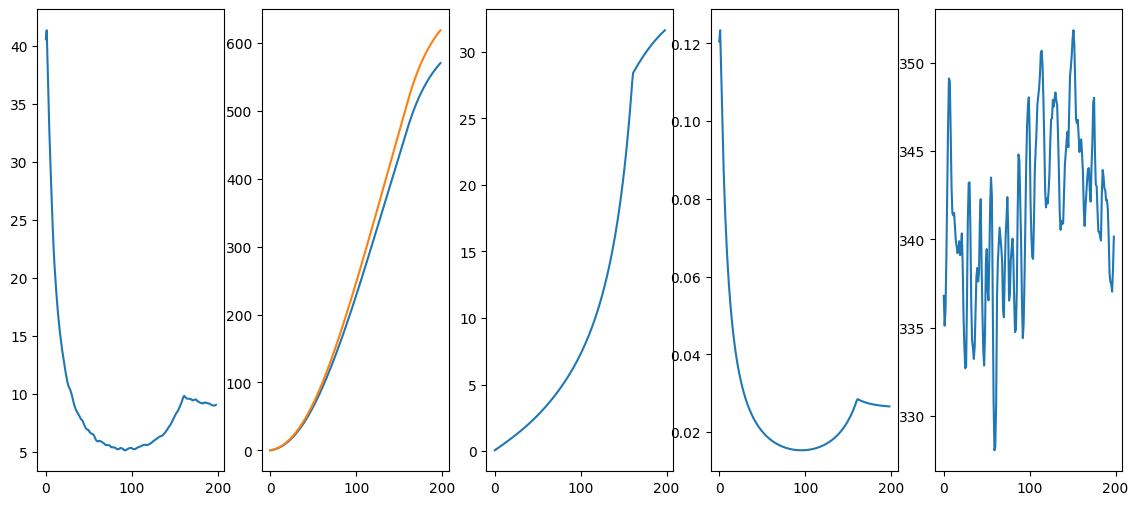

In [25]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [26]:
from copy import deepcopy
import pickle
import sys

batches_iter = 1000

def train_model(opt_state, params, avg_params, model_name, train_new_model=False, energy_method=False, cont=True):
    best_loss = sys.float_info.max # initialization
        
    if cont and os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
      params = avg_params = restore(model_paths, model_name)
    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        key = jax.random.PRNGKey(42)
        subkeys = jax.random.split(key, batches_iter)
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = normalize(data_in_batch)
            label_one_hot = jax.nn.one_hot(label, 63)
            idx = jnp.multiply(jax.random.uniform(key=subkeys[iteration], shape=(batch_size, 1)), timesteps-1).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state = update(params, opt_state, [data_noisy, label_one_hot, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("loss value: ", loss_value)
            
            if iteration % 50 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
                data_noisy_temp, noise_temp = get_noisy(data_in_batch, one_timestep)
                loss_temp = jax.device_get(compute_loss(avg_params, [data_noisy_temp, label_one_hot, one_timestep, noise_temp], energy_method))
                losses.append(loss_temp)
                print('batch loss value', loss_value)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration * batch_size: {iteration*batch_size} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
                    # sample a random number
                    r_ = (jax.random.uniform(subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(einops.rearrange(data_noisy_temp[r_], 'h w c -> 1 h w c'), avg_params, (r_+1)%timesteps)
            
                if iteration % 100 == 0:
                    print(f"iteration * batch_size: {iteration*batch_size} loss: {loss_temp:>7f}")

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params = restore(model_paths, model_name)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params

loss value:  2602.7986
batch loss value 2602.7986
saving iteration * batch_size: 0 loss: 2697.522949
time step for image 158


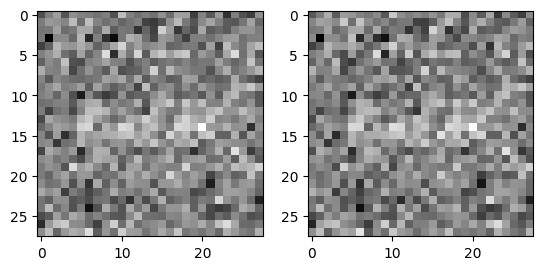

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

iteration * batch_size: 0 loss: 2697.522949
loss value:  2326.192
loss value:  2251.7822
loss value:  2316.746
loss value:  2131.059
loss value:  2282.3992
batch loss value 2282.3992
saving iteration * batch_size: 12800 loss: 2544.991943
time step for image 138


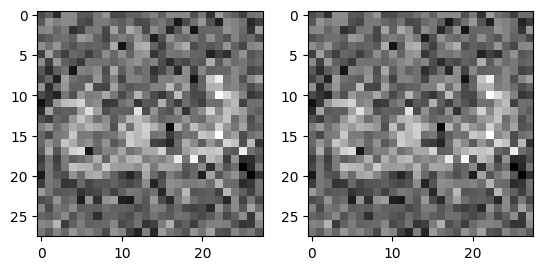

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

loss value:  2226.7139
loss value:  2227.878
loss value:  2321.2554
loss value:  2313.1167


In [ ]:
data_noisy, data_in_batch, timestep, losses, avg_params = train_model(opt_state, params, avg_params, 'emnist_fixed.jax_version', train_new_model = train_new_model, energy_method=False, cont=False)
plt.plot(losses)

## Full generation model

In [ ]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [ ]:
def generate_data(avg_params, energy_method=False, clipped_version=False, labels=None):
    batch_size_generation = 1
    key = jax.random.PRNGKey(42)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(key, shape=(batch_size_generation, 28, 28, 1))
    data_orig = normalize(next(train)[0][0:batch_size_generation])
    data_noisy, _ = get_noisy(data_orig, jnp.array([timesteps]))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy
    key = jax.random.PRNGKey(42)
    subkeys = jax.random.split(key, timesteps)                                 
    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 5:
                x_reconstructed = jnp.clip(x_reconstructed, -1., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch, data_orig

In [ ]:
datas, data_in_batch, data_orig = generate_data(avg_params, energy_method=False, clipped_version=True, labels="mixed")

In [ ]:
_, (plt1, plt2, plt3) = plt.subplots(1, 3)

show_image(unnormalize(data_in_batch[0]), plt1)
show_image(unnormalize(datas[0][0]), plt2)
show_image(unnormalize(data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
huber_loss(datas[0], data_orig), huber_loss(data_in_batch, data_orig), huber_loss(data_in_batch, datas[10])

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for data in datas:
    im = plt.imshow(data[0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full.gif', writer='pillow')

In [ ]:
with open(gifs_dir + 'diffusion_generation_full.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [ ]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 1)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [ ]:
mean_coeff_1 = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2 = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [ ]:
def generate_data(avg_params, energy_method=False, clipped_version=False, labels=None):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 1
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
    key = jax.random.PRNGKey(42)
    # need to generate new keys everytime
    data_noisy = jax.random.normal(key, shape=(batch_size_generation, 28, 28, 1))
    data_orig = normalize(next(train)[0][0:batch_size_generation])
    data_noisy, _ = get_noisy(data_orig, jnp.array([timesteps]))
    
#     if not labels:
#       labelled_values = jnp.zeros((63, batch_size_generation))
#     elif labels=="circles":
#       labelled_values = torch.vstack([torch.ones(batch_size_generation), torch.zeros(batch_size_generation)])
#     elif labels=="moon":
#       labelled_values = torch.vstack([torch.zeros(batch_size_generation), torch.ones(batch_size_generation)])
#     elif labels=="mixed":
#       batch_size_generation_ = int(batch_size_generation/2)
#       labelled_values_1 = torch.vstack([torch.ones(batch_size_generation_), torch.zeros(batch_size_generation_)])
#       labelled_values_2 = torch.vstack([torch.zeros(batch_size_generation_), torch.ones(batch_size_generation_)])
#       labelled_values = torch.hstack([labelled_values_1, labelled_values_2])
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy
    key = jax.random.PRNGKey(42)
    subkeys = jax.random.split(key, len(strided_schedule))                                 
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 5:
                x_reconstructed = jnp.clip(x_reconstructed, -1., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch, data_orig

In [ ]:
datas, data_in_batch, data_orig = generate_data(avg_params, energy_method=False, clipped_version=False, labels="mixed")

In [ ]:
_, (plt1, plt2, plt3) = plt.subplots(1, 3)

show_image(unnormalize(data_in_batch[0]), plt1)
show_image(unnormalize(datas[0][0]), plt2)
show_image(unnormalize(data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
huber_loss(datas[0], data_orig), huber_loss(data_in_batch, data_orig), huber_loss(data_in_batch, datas[50])

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for data in datas:
    im = plt.imshow(data[0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided.gif', writer='pillow')

In [ ]:
with open(gifs_dir + 'diffusion_generation_strided.gif','rb') as f:
  display(Image(data=f.read(), format='png'))